In [1]:
from typing import Optional, List, Tuple
import os
import pandas as pd
import numpy as np
import random
import copy
from scipy.stats import bernoulli

from dataclasses import dataclass
import matplotlib.pyplot as plt

In [2]:
from collections import deque
from queue import PriorityQueue

In [3]:
os.chdir('../Data/md')

In [4]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [5]:
@dataclass
class Order:  # Our own placed order
    order_id: int
    side: str
    size: float
    price: float
    timestamp: float


@dataclass
class AnonTrade:  # Market trade
    timestamp_exchange: int
    timestamp_receive: int
    side: str
    size: float
    price: float


@dataclass
class OwnTrade:  # Execution of own placed order
    timestamp_execution: float
    timestamp_receive: float
    order: Order

@dataclass
class OwnTrades:
    list_of_trades: list


@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    timestamp_exchange: float
    timestamp_receive: float
    asks: List[Tuple[float, float]]  # tuple[price, size]
    bids: List[Tuple[float, float]]


@dataclass
class MdUpdate:  # Data of a tick
    timestamp_exchange: int
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trades: Optional[List[AnonTrade]] = None


@dataclass
class Action: #to place or cancel order
    type: str
    timestamp: float
    order: Order
    cancel_id: int


@dataclass 
class Data: #class to save the data
    orderbook: list
    trades: list
    timestamps: iter
    current_timestamp = None
    o_idx = 0
    t_idx = 0

    def get_deque(self):
        """
        Build deque of MdUpdate
        """
        self.deque = deque()
        while True:
            try:
                self.current_timestamp = next(self.timestamps)
                current_orderbook = []
                current_trades = []
                if self.o_idx != len(self.orderbook):
                    while self.o_idx < len(self.orderbook) and (
                            self.orderbook[self.o_idx].timestamp_exchange == self.current_timestamp):
                        current_orderbook.append(self.orderbook[self.o_idx])
                        self.o_idx += 1
                if self.t_idx != len(self.trades):
                    while self.t_idx < len(self.trades) and (
                            self.trades[self.t_idx].timestamp_exchange == self.current_timestamp):
                        current_trades.append(self.trades[self.t_idx])
                        self.t_idx += 1
                if (len(current_orderbook) > 0):
                    self.deque.append(MdUpdate(self.current_timestamp, current_orderbook[-1], current_trades))
                else:
                    self.deque.append(MdUpdate(self.current_timestamp, None, current_trades))
            except StopIteration:
                break
        return self.deque


@dataclass
class DataUpdate:  #DataUpdate to update values from trade/MdUpdate
    timestamp: float
    ask: float
    bid: float


def prepare_data(path: str, currency: str) -> Data:
    """
    Unpacking data, and create Data class
    """
    lobs = pd.read_csv(f'./{currency}usdt_Binance_LinearPerpetual/lobs.csv', skipinitialspace=True)
    lobs = lobs[lobs.receive_ts <= 1655984000000000000]
    trades = pd.read_csv(f'./{currency}usdt_Binance_LinearPerpetual/trades.csv', skipinitialspace=True)
    trades = trades[trades.receive_ts <= 1655984000000000000]

    lobs.exchange_ts = lobs.exchange_ts.apply(lambda x: x * 1e-6)
    trades.exchange_ts = trades.exchange_ts.apply(lambda x: x * 1e-6)

    lobs.receive_ts = lobs.receive_ts.apply(lambda x: x * 1e-6)
    trades.receive_ts = trades.receive_ts.apply(lambda x: x * 1e-6)

    lobs.rename(columns={"size": "order_size"}, inplace=True)
    trades.rename(columns={"size": "order_size"}, inplace=True)

    columns_ = lobs.columns
    for column in columns_:
        if 'LinearPerpetual' in column:
            lobs.rename(columns={column: column.strip(f'{currency}usdt:Binance:LinearPerpetual')[1:]}, inplace=True)

    timestamps = iter(list(sorted(pd.concat([lobs['exchange_ts'], trades['exchange_ts']], axis=0, join="inner"))))

    orderbooks_updates = list(lobs.progress_apply(lambda x:
                                                  OrderbookSnapshotUpdate(
                                                      x['exchange_ts'],
                                                      x['receive_ts'],
                                                      [(x[f"ask_price_{i}"],
                                                        x[f"ask_vol_{i}"]) for i in range(10)],
                                                      [(x[f"bid_price_{i}"],
                                                        x[f"bid_vol_{i}"]) for i in range(10)])
                                                  , axis=1))

    own_trades = list(trades.progress_apply(lambda x:
                                            AnonTrade(
                                                x['exchange_ts'],
                                                x['receive_ts'],
                                                x['aggro_side'],
                                                x['order_size'],
                                                x['price']), axis=1))
    data = Data(orderbooks_updates, own_trades, timestamps)
    return data


class Strategy:
    def __init__(self, max_position: float, currency, active) -> None:
        self.max_position = max_position #maximal amount of active
        self.trades = []  # all trades history
        self.currency = currency  # amount of currency at the moment
        self.begin_active = active  # amount of active at the t = 0
        self.active = active  # amount of active at the moment
        self.weight = 0.5  # bernoulli parameter
        self.PnL = []  # Capital dynamic through the time
        self.currency_dynamics = [] # currency dynamic through the time
        self.active_dynamics = [] # active dynamic through the time

        self.current_bid = 0 # best bid price at the moment
        self.current_ask = 0 # best ask price at the moment

        self.timestamp = None

    def update_weight(self):
        """Bernoulli random value - it's parameter goes to 0 if amount of active tends to max_pos"""
        weight = (self.max_position - self.active) / (self.max_position)
        if weight > 1:
            self.weight = 1
        elif weight < 0:
            self.weight = 0
        else:
            self.weight = weight

    def run(self, sim: "Sim"):
        """Run simulator.
        Make a tick every iteration, possible outcomes:
        DataUpdate: randomly choose side and place order of size 0.001"
        OwnTrade:  recalculation of Bernoulli parameter, currency and active amount
        OwnTrades: same thing, but for multiple trades"""
        while True:
            try:
                timestamp, priority, update = sim.tick()
                if update == None:
                    break
                self.timestamp = timestamp
                if type(update) == DataUpdate:
                    self.current_bid = update.bid
                    self.current_ask = update.ask
                    sim.place_order(self.current_bid, self.current_ask,
                                    self.weight, 0.001)
                    self.update_weight()
                if type(update) == OwnTrade:
                    self.trades.append(update)
                    if update.order.side == "BID":
                        self.currency -= update.order.price * update.order.size
                        self.active += update.order.size
                    else:
                        self.currency += update.order.price * update.order.size
                        self.active -= update.order.size
                    self.PnL.append(self.active * (self.current_ask + self.current_bid) / 2 + self.currency)
                    self.currency_dynamics.append(self.currency)
                    self.active_dynamics.append(self.active)
                if type(update) == OwnTrades:
                    for trade in update.list_of_trades:
                        self.trades.append(trade)
                        if trade.order.side == "BID":
                            self.currency -= trade.order.price * trade.order.size
                            self.active += trade.order.size
                        else:
                            self.currency += trade.order.price * trade.order.size
                            self.active -= trade.order.size
                        self.PnL.append(self.active * (self.current_ask + self.current_bid) / 2 + self.currency)
                        self.currency_dynamics.append(self.currency)
                        self.active_dynamics.append(self.active)

            except StopIteration:
                break


class Sim:
    def __init__(self, execution_latency: float, md_latency: float, t0: float) -> None:

        self.data = prepare_data("./random/location/md.csv", "btc") #class of Data for simulation

        self.md_queue = self.data.get_deque() #Market data queue
        self.actions_queue = deque() #Actions queue(actually action is a placing or cancelling the order
        self.strategy_updates_queue = PriorityQueue() #Stratrgy updates queue
        self.execution_latency = execution_latency #from strategy to execution
        self.md_latency = md_latency #from exchange to strategy

        self.id_gen = 0 #id_generator for orders
        self.t0 = t0 #time expiration of trade
        self.trade_id_gen = 0 #id_generator for trade
        self.current_md = None #saves current market data
        self.best_ask = 0 #best ask price at the moment
        self.best_bid = 0 #best bid price at the moment
        self.orders = [] #currently active(waiting for) orders
        self.timestamp = None #current timestamp of simulator

    def get_update(self):
        """ 
        Here we try to find MdUpdate or Action before StrategyUpdate
        """
        queue_of_updates = PriorityQueue()
        if len(self.md_queue) > 0:
            queue_of_updates.put((self.md_queue[0].timestamp_exchange, "MdUpdate"))
        if len(self.actions_queue) > 0:
            queue_of_updates.put((self.actions_queue[0].timestamp, "Action"))
        if self.strategy_updates_queue.qsize() > 0:
            queue_of_updates.put((self.strategy_updates_queue.queue[0][0], "StrategyUpdate"))

        if queue_of_updates.qsize() == 0:
            return None, None
        else:
            return queue_of_updates.queue[0][0], queue_of_updates.queue[0][1]

    def tick(self) -> MdUpdate:
        """
        Tick of simulator:
        Possible outcomes of earlies update:
        - MdUpdate: update prices from data(from orderbook/from trade), put update on the strategy queue, 
        execute ready orders at this moment
        - Action: prepare and execute orders(actually place/cancel order)
        - StrategyUpdate: return update to the strategy
        """
        timestamp, update = self.get_update()
        self.timestamp = timestamp
        while update != "StrategyUpdate":
            if (update == "MdUpdate"):
                m = self.md_queue[0]
                if (m.orderbook != None):
                    self.best_ask = m.orderbook.asks[0][0]
                    self.best_bid = m.orderbook.bids[0][0]
                    self.strategy_updates_queue.put((m.orderbook.timestamp_receive, 0,
                                                     DataUpdate(m.orderbook.timestamp_receive,
                                                                self.best_ask,
                                                                self.best_bid)))

                    self.execute_orders()
                else:
                    if (len(m.trades) != 0):
                        for trade in m.trades:
                            if trade.side == 'BID':
                                self.best_bid = trade.price
                            else:
                                self.best_ask = trade.price
                        last_trade = m.trades[-1]
                        self.strategy_updates_queue.put((last_trade.timestamp_receive, 0,
                                                         DataUpdate(last_trade.timestamp_receive,
                                                                    self.best_ask,
                                                                    self.best_bid)))
                        self.execute_orders()
                self.md_queue.popleft()

            elif (update == "Action"):
                self.prepare_orders()
                self.execute_orders()
                self.actions_queue.popleft()

            self.cancel_old_orders()
            timestamp, update = self.get_update()
            self.timestamp = timestamp

            if update == None:
                return None, None, None

        if (self.strategy_updates_queue.qsize() > 0):
            update = self.strategy_updates_queue.get()
        else:
            update = (None, None, None)
        return update

    def prepare_orders(self):
        """
        Check if order is to be placed/cancelled and if put: check if doesn't intersect with other side
        """
        action = self.actions_queue[0]
        if action.type == "PUT":
            if action.order.side == "BID" and self.best_ask > action.order.price:
                self.orders.append(action.order)
            if action.order.side == "ASK" and self.best_bid < action.order.price:
                self.orders.append(action.order)
        if action.type == "CANCEL":
            self.orders = [order for order in self.orders if order.order_id != action.cancel_id]

    def execute_orders(self):
        """
        Go through orders and send list of executed orders to strategy_queue
        """
        remove_orders = list()
        owntrades_list = list()
        for order in self.orders:
            if (order.side == 'BID') and (order.price >= self.best_ask):
                remove_orders.append(order)
                owntrades_list.append(OwnTrade(timestamp_execution=self.timestamp,
                                               timestamp_receive=self.timestamp + self.md_latency,
                                                order = order))
            if (order.side == 'ASK') and (order.price <= self.best_bid):
                remove_orders.append(order)
                owntrades_list.append(OwnTrade(timestamp_execution=self.timestamp,
                                               timestamp_receive=self.timestamp + self.md_latency,
                                               order=order))
        if (len(owntrades_list) > 0):
            self.strategy_updates_queue.put((self.timestamp + self.md_latency, 1, OwnTrades(owntrades_list)))
            self.orders = [order for order in self.orders if order not in remove_orders]

    def place_order(self, bid_price, ask_price, weight, size):
        """
        Choose side of order and put actions into the actions_queue
        """
        rv = bernoulli.rvs(weight)
        type_ = "ASK" if rv == 0 else "BID"
        if type_ == "BID":
            new_order = Order(self.id_gen, type_, size, bid_price, self.timestamp)
        else:
            new_order = Order(self.id_gen, type_, size, ask_price, self.timestamp)
        self.id_gen += 1
        self.actions_queue.append(Action(timestamp=self.timestamp + self.execution_latency,
                                         type="PUT",
                                         order=new_order,
                                         cancel_id=None))
        return new_order.order_id

    def cancel_order(self, order_id):
        """
        Put cancellation action into the action_queue
        """
        self.actions_queue.append(Action(timestamp=self.timestamp + self.execution_latency,
                                         type="CANCEL",
                                         order=None,
                                         cancel_id=order_id))

    def cancel_old_orders(self):
        """
        cancel all expired orders: for any order just call cancellation action
        """
        for order in self.orders:
            if order.timestamp + self.t0 + self.execution_latency <= self.timestamp:
                self.cancel_order(order.order_id)

In [6]:
strategy = Strategy(10, 10000, 5)
sim = Sim(10, 15, 2000)
strategy.run(sim)
print("INITIAL VALUE:", 10000 + 5 * 19977.5)

  0%|          | 0/1228405 [00:00<?, ?it/s]

  0%|          | 0/2511173 [00:00<?, ?it/s]

INITIAL VALUE: 109887.5


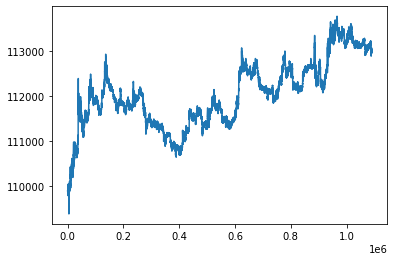

In [7]:
plt.plot(strategy.PnL)

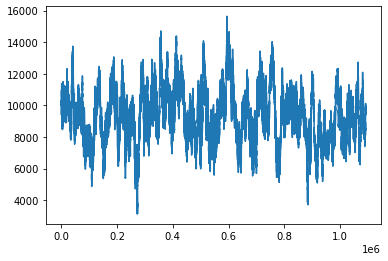

In [8]:
plt.plot(strategy.currency_dynamics)

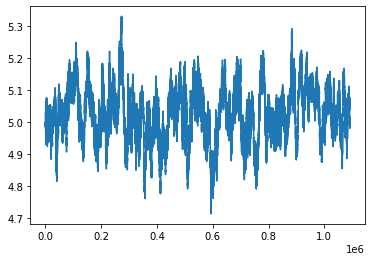

In [9]:
plt.plot(strategy.active_dynamics)